# Memory Based Collaborative Filtering

- https://www.springer.com/gp/book/9783319296579
- https://numpy.org/

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [77]:
USERS: int = 10
ITEMS: int = 15

MIN_RATING: int = 0
MAX_RATING: int = 5
    
MIN_SHARED_RATINGS: int = 3
NOVELTY_DISCOUNT_RATE: float = 0.01
MIN_RECOMMENDATION_RATING: int = 3
ADJACENT_RATINGS: int = 5

## User-Rating Matrix

The ratings matrix is denoted by `R` and it is an `m` by `n` matrix containing `m` users and `n` items. The rating of user `u1` for item `i3` is denoted by `r13`.

$$ U = \{ u_1, u_2 ... u_m \} \land |U| = m $$

$$ I = \{ i_1, i_2 ... i_n \} \land |I| = n $$

$$ R = \{ r_{1,1}, r_{1,2} ... r_{2,1}, r_{2,2} ... r_{m,n} \} \land |R| = m \times n $$

In [3]:
ratings: np.array = MAX_RATING * np.random.randn(USERS, ITEMS)
ratings[ratings < MIN_RATING] = np.nan
ratings[ratings > MAX_RATING] = MAX_RATING
ratings = np.floor(ratings)
print(ratings)

[[ 1. nan  5.  5.  5.  2. nan nan  5. nan nan nan nan  1. nan]
 [nan nan nan nan  5. nan  5. nan nan nan nan nan nan  0. nan]
 [ 5.  2. nan nan  1. nan  2. nan nan nan  5.  5. nan  3.  5.]
 [ 3. nan nan  4.  1. nan  0. nan nan nan  2. nan nan nan nan]
 [nan  5. nan nan  4. nan  2. nan nan nan  1. nan  5.  1.  2.]
 [nan nan nan  2. nan  2.  0.  5.  0.  2.  5. nan  4. nan nan]
 [ 1.  5.  2.  2.  2.  1.  0. nan nan  5. nan  2. nan  5. nan]
 [nan nan nan  0.  5.  5. nan  4. nan nan  2. nan nan nan  5.]
 [ 1. nan  5. nan nan  4.  1.  5. nan nan  5.  0. nan  2.  5.]
 [nan  1. nan  2. nan  0. nan  3. nan nan  3. nan  3.  5. nan]]


In [4]:
missing: np.array = np.isnan(ratings)
print(missing)

[[False  True False False False False  True  True False  True  True  True
   True False  True]
 [ True  True  True  True False  True False  True  True  True  True  True
   True False  True]
 [False False  True  True False  True False  True  True  True False False
   True False False]
 [False  True  True False False  True False  True  True  True False  True
   True  True  True]
 [ True False  True  True False  True False  True  True  True False  True
  False False False]
 [ True  True  True False  True False False False False False False  True
  False  True  True]
 [False False False False False False False  True  True False  True False
   True False  True]
 [ True  True  True False False False  True False  True  True False  True
   True  True False]
 [False  True False  True  True False False False  True  True False False
   True False False]
 [ True False  True False  True False  True False  True  True False  True
  False False  True]]


## Views Matrix

In [5]:
views: np.array = np.floor(np.random.lognormal(0, 1, ratings.size)).reshape(ratings.shape)
print(views)

[[ 0.  0. 10.  0.  0.  2.  0.  0.  0.  8.  2.  1.  4.  0.  0.]
 [ 8.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  2.  0.]
 [ 0.  0.  6.  0.  2.  2.  3.  1.  1.  2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  3.  0.  1.  0.  4.  6.  1.  0.  1.  2.  0.]
 [ 0.  3.  0.  0.  0.  1.  0.  0.  1.  2.  1.  0.  1.  0.  0.]
 [ 3.  2.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  6.  3.  0.  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  3.]
 [ 1.  0.  1.  0.  3.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.]
 [ 8.  1.  0.  1.  1.  0.  0.  3.  0.  2.  0.  0.  1.  0.  0.]]


## Normalization

- https://en.wikipedia.org/wiki/Normalization_(statistics)

In statistics and applications of statistics, normalization can have a range of meanings. In the simplest cases, normalization of ratings means adjusting values measured on different scales to a notionally common scale, often prior to averaging.

$$ \bar{\mu} = \frac{\sum\limits^{^n}_{i=1} x_i}{n}	 $$

$$ σ^2 = \frac{\sum\limits^{^n}_{i=1} (x_i - \bar{\mu})^2}{n}	 $$

$$ z = \frac{x_i - \bar{\mu}}{σ}	 $$

In [6]:
def get_normalized_matrix(matrix: np.array) -> tuple:
    """
    Normalization Function.
    Returns z-score of each element in the input matrix.
    """    
    sample_size: np.array = np.sum(~np.isnan(matrix), axis=1)
    sample_size[sample_size == 0] = 1    
    mean: np.array = np.nansum(matrix, axis=1) / sample_size
    mean = mean.reshape(mean.shape[0], 1)
    variance: np.array = np.nansum(np.power(matrix - mean, 2), axis=1) / sample_size
    variance = variance.reshape(variance.shape[0], 1)
    variance[variance == 0] = 1
    deviation: np.array = np.sqrt(variance)
    normalized: np.array = (matrix - deviation) / deviation
    return mean, deviation, normalized

ORIGINAL [[-0.21722402  1.40199002  4.11070025  3.07130611  3.93533514  6.18822122
   6.94021132  6.75407262 10.9300675  11.69287465]
 [19.42680681 25.26639004 32.39626192 41.47101692 46.27925615 52.2750375
  60.15181682 65.71939964 74.89980003 79.00474361]]
NORMALIZED [[-1.05985441e+00 -6.13692414e-01  1.32671895e-01 -1.53725181e-01
   8.43513832e-02  7.05116846e-01  9.12321946e-01  8.61032855e-01
   2.01169618e+00  2.22188184e+00]
 [ 2.04847261e-03  3.03258317e-01  6.71022165e-01  1.13910446e+00
   1.38711685e+00  1.69638351e+00  2.10267337e+00  2.38985324e+00
   2.86338480e+00  3.07512071e+00]]


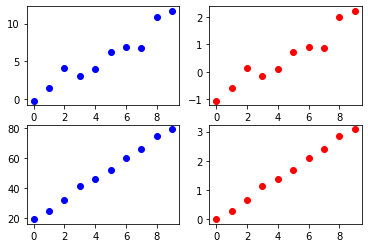

In [7]:
x: np.array = np.vstack([
    np.linspace(0, 10, 10) + np.random.normal(0, 1, 10),
    20 + np.linspace(0, 60, 10) + np.random.normal(0, 1, 10),
])
mean, deviation, y = get_normalized_matrix(x)
assert x.shape == y.shape
print('ORIGINAL', x)
print('NORMALIZED', y)
grid = np.arange(x.shape[1])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot(2, 2, 1)
axes.plot(grid, x[0].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 2)
axes.plot(grid, y[0].flat, 'o', color='red')
axes: Axes = figure.add_subplot(2, 2, 3)
axes.plot(grid, x[1].flat, 'o', color='blue')
axes: Axes = figure.add_subplot(2, 2, 4)
axes.plot(grid, y[1].flat, 'o', color='red')
plt.show()

## Entropy

- https://en.wikipedia.org/wiki/Entropy_(information_theory)

In information theory, the entropy of a random variable is the average level of "information", "surprise", or "uncertainty" inherent in the variable's possible outcomes.

$$ H(x) = - \sum\limits^{^n}_{i=1} P(x_i) \cdot log P(x_i) $$

In [8]:
def get_entropy_array(matrix: np.array) -> np.array:
    """
    Entropy Matrix.
    """
    P: np.matrix = np.count_nonzero(~np.isnan(matrix.T), axis=1) / matrix.shape[0]
    P[P == 0] = 1
    return np.abs(np.log(P))

In [9]:
X: np.array = np.array([
    [1, np.nan, 3, np.nan, np.nan],
    [4, 5, np.nan, np.nan, np.nan],
    [7, 8, 9, 5, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [7, 8, 9, np.nan, np.nan],
    [1, 2, 2, np.nan, np.nan]
])
E: np.array = get_entropy_array(X)
print(X)
print(E)

[[ 1. nan  3. nan nan]
 [ 4.  5. nan nan nan]
 [ 7.  8.  9.  5. nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 7.  8.  9. nan nan]
 [ 1.  2.  2. nan nan]]
[0.         0.13353139 0.13353139 2.07944154 0.        ]


## Cosine Similarity

- https://en.wikipedia.org/wiki/Cosine_similarity

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. It is defined to equal the cosine of the angle between them, which is also the same as the inner product of the same vectors normalized to both have length 1.

$$ cos(X, Y) = \frac{X \cdot Y}{ \left \Vert X \right \| \cdot \left \Vert Y \right \| } = \frac{ \sum\limits^{^n}_{i=1} X_i \cdot Y_i }{ \sqrt{\sum\limits^{^n}_{i=1} X_i^2} \cdot \sqrt{\sum\limits^{^n}_{i=1} Y_i^2} } $$

In [10]:
def get_cosine(X: np.array, Y: np.array) -> float:
    """
    Cosine Similarity function.
    """
    union: np.array = ~np.isnan(np.sum([X, Y], axis=0))
    if np.count_nonzero(union) == 0:
        return 0
    discount: float = min(MIN_SHARED_RATINGS, np.count_nonzero(union)) / MIN_SHARED_RATINGS
    return discount * np.sum(X[union] * Y[union]) / \
        (max(0.0000001, np.sqrt(np.sum(np.power(X[union], 2)))) *\
         max(0.0000001, np.sqrt(np.sum(np.power(Y[union], 2)))))

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 1.  3.  2.  2. nan  8.  9. 10. 11. 12.] 0.9929196160911488


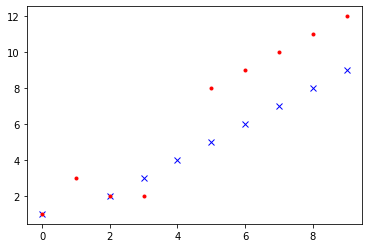

In [11]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([1, 3, 2, 2, np.nan, 8, 9, 10, 11, 12])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  6.  7.  8.  9.] [ 10.  30.  20.  20.  nan  80.  90. 100. 110. 120.] 0.9929196160911488


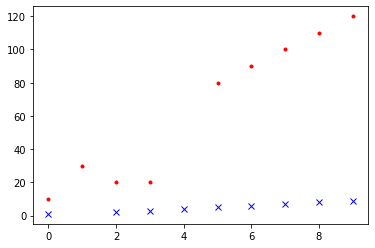

In [12]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 6, 7, 8, 9])
Y: np.array = np.array([10, 30, 20, 20, np.nan, 80, 90, 100, 110, 120])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, '.', color='red')
plt.show()

[ 1. nan  2.  3.  4.  5.  7.  9. 10.] [100.  65.  32.  24.  nan  10.   7.   4.   2.] 0.21975098781417202


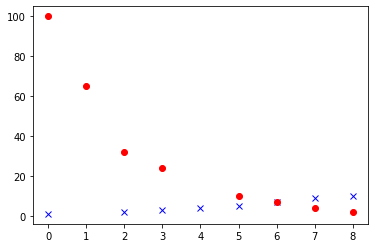

In [13]:
X: np.array = np.array([1, np.nan, 2, 3, 4, 5, 7, 9, 10])
Y: np.array = np.array([100, 65, 32, 24, np.nan, 10, 7, 4, 2])
print(X, Y, get_cosine(X, Y))
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, 'x', color='blue')
axes.plot(np.arange(Y.shape[0]), Y, 'o', color='red')
plt.show()

## Similarity Matrix

In [14]:
def get_similarity_matrix(matrix: np.array) -> np.array:
    """
    Get similarity matrix out of a given matrix.
    """
    correlations: np.array = np.stack([
        [
            0 if i >= j else get_cosine(x, y)
            for j, y in enumerate(matrix)
        ]
        for i, x in enumerate(matrix)
    ])
    return correlations + correlations.T

In [15]:
X: np.array = np.array([ [1, 2, 3], [4, 5, 6], [7, 8, 9] ])
S: np.array = get_similarity_matrix(X)
print(X)
print(S)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[0.         0.97463185 0.95941195]
 [0.97463185 0.         0.99819089]
 [0.95941195 0.99819089 0.        ]]


## Top K-Similar Rows

- https://en.wikipedia.org/wiki/Adjacency_matrix
- https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

In graph theory and computer science, an adjacency matrix is a square matrix used to represent a finite graph. The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph.

In [16]:
def get_adjacency_matrix(similar: np.array, k: int = ADJACENT_RATINGS) -> np.array:
    """
    Get top k similar rows of a similarity matrix.
    """
    closest: np.array = np.argsort(similar)
    return closest[:, closest.shape[1] - k:]

In [17]:
X: np.array = np.array([ [0, 2, 3, 1], [8, 0, 6, 1], [7, 6, 0, 2], [2, 3, 1, 0] ])
S: np.array = get_adjacency_matrix(X, 2)
print(X)
print(S)

[[0 2 3 1]
 [8 0 6 1]
 [7 6 0 2]
 [2 3 1 0]]
[[1 2]
 [2 0]
 [1 0]
 [0 1]]


## Collaborative Filtering

Filling the collaborative filtering matrix with ratings from similar rows. The predicted value is the weighted sum of the adjacent rows. Values are denormalized so that the approximate user scores. Entropy is applied to promote novelty across recommendations.

$$ \hat{R_{i,j}} = \mu + σ \cdot \frac{ \sum\limits^{^n}_{u=1} w_u \cdot R_{u,j} }{ \sum\limits^{^n}_{u=1} w_u } $$

In [18]:
def get_collaborative_filtering(ratings: np.array, normalized: np.array, mean: np.array, deviation: np.array, entropy: np.array, adjacent: np.array, similarity: np.array) -> np.matrix:
    """
    Collaborative Filtering function.
    """
    recommendations: np.array = np.zeros(ratings.shape)
    for i in range(normalized.shape[0]):
        for j in range(normalized.shape[1]):
            recommendations[i, j] = ratings[i][j]
            if np.isnan(normalized[i][j]):
                total: float = 0
                weights: float = 0
                y_hat: float = np.nan
                for k in adjacent[i]:
                    if np.isnan(normalized[k][j]):
                        continue
                    weight: float = similarity[i][k] * entropy[k]
                    weights += weight
                    total += normalized[k][j] * weight
                if weights > 0:
                    y_hat: float = mean[i].flat[0] + deviation[i].flat[0] * total / weights
                recommendations[i, j] = y_hat
    return recommendations

## Novelty

- http://ir.ii.uam.es/saul/pubs/fdia11-vargas.pdf

In case we consider an item in a recommendation list, the probability of been discovered, i.e. p(seen|i, R), can be simplified by a decreasing discount function disc. Novelty of an item as the probability of not having been seen. In case we were interested in emphasize highly novel items, a discount rate `d` is applied on `t` times seen.

$$ \hat{R_{u,i}} = R_{u,i} \cdot P(seen/u,i) $$

$$ P(seen/u,i) = \frac{1}{(1 + d)^t} $$

[1.         0.99009901 0.98029605 0.97059015 0.96098034 0.95146569
 0.94204524 0.93271805 0.92348322 0.91433982 0.90528695 0.89632372
 0.88744923 0.8786626  0.86996297]


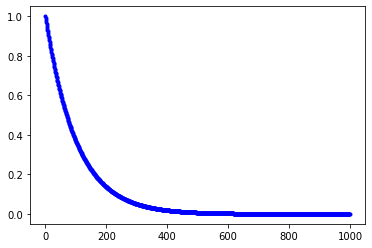

In [19]:
dicount: float = 0.01
X: np.array = 1 / (1 + dicount) ** np.arange(1000)
print(X[:15])
figure: Figure = plt.figure()
axes: Axes = figure.add_subplot()
axes.plot(np.arange(X.shape[0]), X, '.', color='blue')
plt.show()

In [20]:
def get_novelty_matrix(recommendations: np.array, views: np.array) -> np.array:
    """
    Apply novelty to recommendations.
    """
    return recommendations / (1 + NOVELTY_DISCOUNT_RATE) ** views

In [21]:
X: np.array = np.array([
    [3, 5, 8],
    [2, 2, 2],
    [1, 0, 5],
])
V: np.array = np.array([
    [5, 0, 100],
    [0, 10, 20],
    [1, 0, 100],
])
Y:np.array = get_novelty_matrix(X, V)
print(NOVELTY_DISCOUNT_RATE)
print(Y)

0.01
[[2.85439706 5.         2.9576897 ]
 [2.         1.81057391 1.63908894]
 [0.99009901 0.         1.84855606]]


## User-Based Collaborative Filtering

#### User-User Matrix

In [22]:
user_user: np.matrix = np.copy(ratings)
print(user_user.shape)
print(user_user)

(10, 15)
[[ 1. nan  5.  5.  5.  2. nan nan  5. nan nan nan nan  1. nan]
 [nan nan nan nan  5. nan  5. nan nan nan nan nan nan  0. nan]
 [ 5.  2. nan nan  1. nan  2. nan nan nan  5.  5. nan  3.  5.]
 [ 3. nan nan  4.  1. nan  0. nan nan nan  2. nan nan nan nan]
 [nan  5. nan nan  4. nan  2. nan nan nan  1. nan  5.  1.  2.]
 [nan nan nan  2. nan  2.  0.  5.  0.  2.  5. nan  4. nan nan]
 [ 1.  5.  2.  2.  2.  1.  0. nan nan  5. nan  2. nan  5. nan]
 [nan nan nan  0.  5.  5. nan  4. nan nan  2. nan nan nan  5.]
 [ 1. nan  5. nan nan  4.  1.  5. nan nan  5.  0. nan  2.  5.]
 [nan  1. nan  2. nan  0. nan  3. nan nan  3. nan  3.  5. nan]]


#### User-User Normalized Matrix

In [23]:
mean, deviation, normalized = get_normalized_matrix(user_user)
print(normalized.shape)
print(normalized)

(10, 15)
[[-0.45669463         nan  1.71652684  1.71652684  1.71652684  0.08661074
          nan         nan  1.71652684         nan         nan         nan
          nan -0.45669463         nan]
 [        nan         nan         nan         nan  1.12132034         nan
   1.12132034         nan         nan         nan         nan         nan
          nan -1.                 nan]
 [ 2.16227766  0.26491106         nan         nan -0.36754447         nan
   0.26491106         nan         nan         nan  2.16227766  2.16227766
          nan  0.8973666   2.16227766]
 [ 1.12132034         nan         nan  1.82842712 -0.29289322         nan
  -1.                 nan         nan         nan  0.41421356         nan
          nan         nan         nan]
 [        nan  2.04635898         nan         nan  1.43708718         nan
   0.21854359         nan         nan         nan -0.3907282          nan
   2.04635898 -0.3907282   0.21854359]
 [        nan         nan         nan  0.06904497       

#### User-User Similarity Matrix

In [24]:
similarity: np.array = get_similarity_matrix(normalized)
print(similarity.shape)
print(similarity)

(10, 10)
[[ 0.          0.59491054 -0.46666736  0.39715224  0.66665681 -0.6523019
   0.00916065  0.20247175  0.8377795  -0.12702141]
 [ 0.59491054  0.         -0.53722173 -0.58490347  0.79635019 -0.33333333
  -0.71010669  0.33333333 -0.51153351 -0.33333333]
 [-0.46666736 -0.53722173  0.          0.64522565 -0.07815627  0.5263519
   0.13400525  0.42901782  0.30030672  0.69118012]
 [ 0.39715224 -0.58490347  0.64522565  0.         -0.47475545  0.43903929
   0.28180216 -0.62648127  0.21950705  0.34573229]
 [ 0.66665681  0.79635019 -0.07815627 -0.47475545  0.          0.30817829
   0.42890938  0.77121991 -0.26803104  0.00809148]
 [-0.6523019  -0.33333333  0.5263519   0.43903929  0.30817829  0.
   0.50937507  0.3803525   0.90440463  0.833575  ]
 [ 0.00916065 -0.71010669  0.13400525  0.28180216  0.42890938  0.50937507
   0.         -0.50765308  0.07538747  0.60922281]
 [ 0.20247175  0.33333333  0.42901782 -0.62648127  0.77121991  0.3803525
  -0.50765308  0.          0.81781791 -0.20481185]
 [

#### User-User Adjacency Matrix

In [25]:
adjacent: np.array = get_adjacency_matrix(similarity)
print(adjacent.shape)
print(adjacent)

(10, 5)
[[7 3 1 4 8]
 [9 1 7 0 4]
 [8 7 5 3 9]
 [6 9 0 5 2]
 [5 6 0 7 1]
 [3 6 2 9 8]
 [2 3 4 5 9]
 [1 5 2 4 8]
 [9 2 7 0 5]
 [8 3 6 2 5]]


#### Users Entropy Matrix

In [26]:
entropy: np.array = get_entropy_array(user_user.T)
print(entropy.shape)
print(entropy)

(10,)
[0.76214005 1.60943791 0.62860866 1.09861229 0.76214005 0.62860866
 0.40546511 0.91629073 0.51082562 0.76214005]


#### User-User Collaborative Filtering

In [27]:
recommendations: np.matrix = get_collaborative_filtering(ratings=user_user,
                                                         normalized=normalized,
                                                         mean=mean,
                                                         deviation=deviation,
                                                         similarity=similarity,
                                                         entropy=entropy,
                                                         adjacent=adjacent)
print(recommendations)

[[ 1.          7.19507016  5.          5.          5.          2.
   3.85340264  6.02480006  5.                 nan  4.19833856  1.5879859
   7.19507016  1.          5.19173302]
 [ 2.25689376 12.19336465  7.3792259   5.14402727  5.          7.04374344
   5.          7.24821632  7.3792259          nan  1.63443975         nan
   9.92831678  0.          4.97112529]
 [ 5.          2.          5.93415835  4.38934089  1.          3.83729993
   2.          5.47633236  1.91886117  3.60916968  5.          5.
   5.16757746  3.          5.        ]
 [ 3.          2.4200675   3.81856     4.          1.          1.60511279
   0.          3.90240036  2.5952965   2.84046703  2.          4.43094251
   3.51568706  3.37304427  5.05792239]
 [ 2.11982832  5.          5.01683417  3.06885126  4.          4.04263741
   2.          4.88163937  4.44374503  4.36331863  1.          3.09545467
   5.          1.          2.        ]
 [ 3.68767782  2.91659302  4.57426938  2.          2.07272921  2.
   0.          5

#### User-User Novelty Recommendations

In [28]:
recommendations: np.matrix = get_novelty_matrix(recommendations, views)
print(recommendations)

[[ 1.          7.19507016  4.52643477  5.          5.          1.9605921
   3.85340264  6.02480006  5.                 nan  4.11561471  1.57226326
   6.914321    1.          5.19173302]
 [ 2.08420352 12.19336465  7.3792259   5.14402727  5.          6.97400341
   5.          7.24821632  7.3792259          nan  1.63443975         nan
   9.92831678  0.          4.97112529]
 [ 5.          2.          5.5902456   4.38934089  0.98029605  3.76168996
   1.9411803   5.42211125  1.89986254  3.53805478  4.95049505  5.
   5.16757746  3.          5.        ]
 [ 3.          2.4200675   3.81856     4.          1.          1.60511279
   0.          3.71300004  2.5952965   2.84046703  2.          4.43094251
   3.44641413  3.37304427  5.05792239]
 [ 2.11982832  5.          5.01683417  3.06885126  3.88236059  4.04263741
   1.98019802  4.88163937  4.27035163  4.11044353  0.99009901  3.09545467
   4.95049505  0.98029605  2.        ]
 [ 3.68767782  2.83081645  4.57426938  2.          2.07272921  1.98019802


## Memory-Based Collaborative Filtering

#### Item-Item Matrix

In [29]:
item_item: np.array = np.copy(ratings.T)
print(item_item.shape)
print(item_item)

(15, 10)
[[ 1. nan  5.  3. nan nan  1. nan  1. nan]
 [nan nan  2. nan  5. nan  5. nan nan  1.]
 [ 5. nan nan nan nan nan  2. nan  5. nan]
 [ 5. nan nan  4. nan  2.  2.  0. nan  2.]
 [ 5.  5.  1.  1.  4. nan  2.  5. nan nan]
 [ 2. nan nan nan nan  2.  1.  5.  4.  0.]
 [nan  5.  2.  0.  2.  0.  0. nan  1. nan]
 [nan nan nan nan nan  5. nan  4.  5.  3.]
 [ 5. nan nan nan nan  0. nan nan nan nan]
 [nan nan nan nan nan  2.  5. nan nan nan]
 [nan nan  5.  2.  1.  5. nan  2.  5.  3.]
 [nan nan  5. nan nan nan  2. nan  0. nan]
 [nan nan nan nan  5.  4. nan nan nan  3.]
 [ 1.  0.  3. nan  1. nan  5. nan  2.  5.]
 [nan nan  5. nan  2. nan nan  5.  5. nan]]


#### Item-Item Normalized Matrix

In [30]:
mean, deviation, normalized = get_normalized_matrix(item_item)
print(normalized.shape)
print(normalized)

(15, 10)
[[-0.375              nan  2.125       0.875              nan         nan
  -0.375              nan -0.375              nan]
 [        nan         nan  0.12022407         nan  1.80056017         nan
   1.80056017         nan         nan -0.43988797]
 [ 2.53553391         nan         nan         nan         nan         nan
   0.41421356         nan  2.53553391         nan]
 [ 2.11085508         nan         nan  1.48868407         nan  0.24434203
   0.24434203 -1.                 nan  0.24434203]
 [ 1.85773803  1.85773803 -0.42845239 -0.42845239  1.28619043         nan
   0.14309521  1.85773803         nan         nan]
 [ 0.17669681         nan         nan         nan         nan  0.17669681
  -0.41165159  1.94174203  1.35339362 -1.        ]
 [        nan  1.97939786  0.19175914 -1.          0.19175914 -1.
  -1.                 nan -0.40412043         nan]
 [        nan         nan         nan         nan         nan  5.03022689
          nan  3.82418151  5.03022689  2.61813613]

#### Item-Item Similarity Matrix

In [31]:
similarity: np.array = get_similarity_matrix(normalized)
print(similarity.shape)
print(similarity)

(15, 15)
[[ 0.         -0.07186064 -0.8773552   0.15798714 -0.44052848 -0.45295184
   0.01687495 -0.33333333 -0.33333333 -0.33333333  0.56207328  0.89619637
   0.          0.19886071  0.38230823]
 [-0.07186064  0.          0.33333333  0.34605977  0.72573468 -0.10021712
  -0.54224748 -0.33333333  0.          0.33333333 -0.18010748  0.03203126
   0.50091739  0.24096932  0.16742428]
 [-0.8773552   0.33333333  0.          0.66594012  0.66425649  0.72078264
  -0.34617425  0.33333333  0.33333333  0.33333333  0.33333333 -0.66057683
   0.         -0.03541746  0.33333333]
 [ 0.15798714  0.34605977  0.66594012  0.          0.19707614 -0.35232
  -0.74701435 -0.27020523  0.4140722   0.53333333  0.20274666 -0.33333333
   0.65538735 -0.02369217 -0.33333333]
 [-0.44052848  0.72573468  0.66425649  0.19707614  0.          0.7393601
   0.71938284  0.33333333  0.33333333  0.33333333 -0.19497436 -0.63615213
   0.33333333 -0.51376062  0.50980415]
 [-0.45295184 -0.10021712  0.72078264 -0.35232     0.7393601

#### Item-Item Adjacency Matrix

In [32]:
adjacent: np.array = get_adjacency_matrix(similarity)
print(adjacent.shape)
print(adjacent)

(15, 5)
[[ 3 13 14 10 11]
 [ 2  9  3 12  4]
 [10 14  4  3  5]
 [ 1  8  9 12  2]
 [14  2  6  1  5]
 [10  7 14  2  4]
 [ 6  0  8 11  4]
 [13  5 14 12 10]
 [14  2  4  6  3]
 [ 7 10 12 13  3]
 [13 12  0 14  7]
 [10 14 13  6  0]
 [14  1 10  3  7]
 [ 1  9  7 10 14]
 [ 4 13  5  7 10]]


#### Items Entropy Matrix

In [33]:
entropy: np.array = get_entropy_array(item_item.T)
print(entropy.shape)
print(entropy)

(15,)
[0.69314718 0.91629073 1.2039728  0.51082562 0.35667494 0.51082562
 0.35667494 0.91629073 1.60943791 1.60943791 0.35667494 1.2039728
 1.2039728  0.35667494 0.91629073]


#### Item-Item Collaborative Filtering

In [34]:
recommendations: np.matrix = get_collaborative_filtering(ratings=item_item,
                                                         normalized=normalized,
                                                         mean=mean,
                                                         deviation=deviation,
                                                         similarity=similarity,
                                                         entropy=entropy,
                                                         adjacent=adjacent)
print(recommendations)

[[1.         0.6        5.         3.         2.41413799 4.78626018
  1.         4.66008591 1.         3.66386401]
 [7.24242956 6.5667258  2.         3.87400928 5.         6.74037607
  5.         4.49631779 7.77683348 1.        ]
 [5.         6.62723832 6.19540296 4.88737013 4.91108105 4.69410199
  2.         5.77277702 5.         3.69583988]
 [5.                nan 2.69323315 4.         9.20411722 2.
  2.         0.         6.57530058 2.        ]
 [5.         5.         1.         1.         4.         2.76201175
  2.         5.         6.75167812 2.16108967]
 [2.         5.49088083 5.54679812 1.98913489 3.39108084 2.
  1.         5.         4.         0.        ]
 [3.53217008 5.         2.         0.         2.         0.
  0.         4.54621151 1.                nan]
 [4.24333823 3.4208438  6.22627551 4.47179965 6.14488773 5.
  4.42332713 4.         5.         3.        ]
 [5.         7.29641986 2.20413344 3.3071044  4.34743696 0.
  2.84103709 2.57075178 7.15924203 3.11085508]
 [5.4

#### Item-Item Novelty Recommendations

In [35]:
recommendations: np.matrix = get_novelty_matrix(recommendations, views.T)
print(recommendations)

[[1.         0.55408993 5.         3.         2.41413799 4.78626018
  0.97059015 4.66008591 0.99009901 3.38351695]
 [7.24242956 6.5667258  2.         3.87400928 5.         6.5421426
  4.90148025 4.23573475 7.77683348 0.99009901]
 [4.52643477 6.62723832 5.83634984 4.88737013 4.91108105 4.69410199
  2.         5.6030005  4.95049505 3.69583988]
 [5.                nan 2.69323315 4.         9.20411722 2.
  2.         0.         6.57530058 1.98019802]
 [5.         5.         0.98029605 1.         3.88236059 2.76201175
  1.98019802 5.         6.55311226 2.13969274]
 [1.9605921  5.43651567 5.43750429 1.98913489 3.39108084 1.98019802
  1.         4.95049505 4.         0.        ]
 [3.53217008 5.         1.9411803  0.         1.98019802 0.
  0.         4.54621151 0.99009901        nan]
 [4.24333823 3.4208438  6.16462921 4.25476393 6.14488773 5.
  4.42332713 4.         4.95049505 2.91177044]
 [5.         7.29641986 2.18231033 3.3071044  4.17780147 0.
  2.84103709 2.57075178 7.15924203 3.11085508

#### Trending Items

In [36]:
trending: np.array = np.nansum(recommendations, axis=1) / np.count_nonzero(~np.isnan(recommendations), axis=1)
print(trending)

[2.67587801 4.91294547 4.77319115 3.71698322 3.42976714 3.01455209
 1.99887321 4.55140555 3.7645522  5.23745985 3.09816817 3.2184625
 5.00161566 3.33915499 4.93133085]


#### Explaining Recommendtions

In [130]:
print(0, "\n", user_user)
for i in range(user_user.shape[0]):
    print(f'User #{i}:')
    for j in range(user_user.shape[1]):
        if np.isnan(user_user[i][j]):
            u = np.take(user_user, adjacent[j])
            v = adjacent[j][np.nanargmax(u)]
            print(f'\tis recommended {j} because you watched: {v}')
            break
    break

x = item_item[adjacent].T
x[np.isnan(x)] = -1
for user in x:
    print(user.T)
    print(np.nanargmax(user.T, axis=1))
# MIN_RECOMMENDATION_RATING  # T
# print(x[0][1])
# print(111111111, "\n", x[:,:].T)
# print(np.nanargmax(x, axis=2))
# print(x)
# missing # TODO
# watched  # TODO

0 
 [[ 1. nan  5.  5.  5.  2. nan nan  5. nan nan nan nan  1. nan]
 [nan nan nan nan  5. nan  5. nan nan nan nan nan nan  0. nan]
 [ 5.  2. nan nan  1. nan  2. nan nan nan  5.  5. nan  3.  5.]
 [ 3. nan nan  4.  1. nan  0. nan nan nan  2. nan nan nan nan]
 [nan  5. nan nan  4. nan  2. nan nan nan  1. nan  5.  1.  2.]
 [nan nan nan  2. nan  2.  0.  5.  0.  2.  5. nan  4. nan nan]
 [ 1.  5.  2.  2.  2.  1.  0. nan nan  5. nan  2. nan  5. nan]
 [nan nan nan  0.  5.  5. nan  4. nan nan  2. nan nan nan  5.]
 [ 1. nan  5. nan nan  4.  1.  5. nan nan  5.  0. nan  2.  5.]
 [nan  1. nan  2. nan  0. nan  3. nan nan  3. nan  3.  5. nan]]
User #0:
	is recommended 1 because you watched: 2
[[ 5.  1. nan nan nan]
 [ 5. nan  5. nan  5.]
 [nan nan  5.  5.  2.]
 [nan  5. nan nan  5.]
 [nan  5. nan nan  2.]
 [nan nan nan  5.  5.]
 [nan  1.  5. nan  5.]
 [ 1.  2. nan nan nan]
 [nan  5.  5. nan  5.]
 [nan nan nan  1.  5.]
 [ 1. nan  1. nan nan]
 [nan nan  1. nan  1.]
 [nan nan nan  5. nan]
 [nan nan nan na

ValueError: All-NaN slice encountered